In [1]:
%matplotlib inline
import argparse
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from collections import Counter

In [2]:
genes_df=pd.read_table("U00096.3.gtf",header=None)
genes_df["Gene name"]=genes_df[8].apply(lambda x: x.split(';')[4].split('=')[1])
genes_df=genes_df.loc[:,[6,'Gene name']]

In [21]:
sample='bm03'
plus_df=pd.read_table('2018-05-22_RNAseq/bm03_fwd_end50genes.txt',header=None)
plus_df=plus_df.iloc[0:4419,:]
plus_df.columns=['Gene name','plus_count']
plus_df=plus_df.merge(genes_df, on ='Gene name')
minus_df=pd.read_table('2018-05-22_RNAseq/bm03_rev_end50genes.txt',header=None)
minus_df=minus_df.iloc[0:4419,:]
minus_df.columns=['Gene name','minus_count']
minus_df=minus_df.merge(genes_df, on ='Gene name')
merge_df=pd.merge(plus_df,minus_df)
plusgenes_df=merge_df[merge_df[6]=='+']
plusgenes_df.columns=['Gene name',sample+'_TS',6,sample+'_NTS']
minusgenes_df=merge_df[merge_df[6]=='-']
minusgenes_df.columns=['Gene name',sample+'_NTS',6,sample+'_TS']
joined_df=pd.concat([plusgenes_df,minusgenes_df])
joined_df=joined_df.sort_index()

/Users/britney/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  from ipykernel import kernelapp as app


In [22]:
filtered=joined_df[joined_df['bm03_NTS']/joined_df['bm03_TS']>2]

In [23]:
filtered=filtered[filtered['bm03_NTS']>20]

In [6]:
#filtered.to_csv('test_high_NTS')

In [24]:
filtered

Gene name  bm03_TS  6  bm03_NTS
3         aaeX       17  -       136
12        abrB       19  -        43
31        acrD       23  +      3420
50         aes       30  -        61
57        agaS       10  +        24
...        ...      ... ..       ...
4030      ytfE       46  -       169
4041      ytiA        6  -        53
4044      yzcX       37  +        93
4045      yzfA        0  -       106
4046      yzgL       74  -      1782

[183 rows x 4 columns]

In [9]:
joined_df[joined_df['bm03_NTS']>joined_df['bm03_TS']]

Gene name  bm03_TS  6  bm03_NTS
2         aaeR       28  +        43
3         aaeX       17  -       136
7         abgB        3  -        17
8         abgR       22  +        39
12        abrB       19  -        43
...        ...      ... ..       ...
4041      ytiA        6  -        53
4044      yzcX       37  +        93
4045      yzfA        0  -       106
4046      yzgL       74  -      1782
4061      zraP       16  -        32

[492 rows x 4 columns]

In [8]:
def readgenome(fasta): #for genes in the '+' orientation, reading would give the NTS (coding)
    genome=""
    with open(fasta,"r") as file1:
        for line in file1:
            if line.startswith(">"):
                pass
            else:
                genome=genome+''.join(line.rstrip())
   
   
    return genome

def complement(gene): #for genes in the '+' orientation, the complement genome would give the TS 
    code={"A":"T","T":"A","G":"C","C":"G"}
    minus_strand=""
    for nuc in gene:
        minus_strand=minus_strand+code[nuc]
    return minus_strand

In [9]:
plus_genome=complement(readgenome("U00096.3.fa")) #I am calling the compliment genome plus (plus would refer to TS of plus genes)
minus_genome=readgenome("U00096.3.fa") #the minus is the original read-in and would refer to the TS of minus genes

In [10]:
#the files here were made with pos_count.py script and alignment bedfiles
p_data=pd.read_csv('2020-06-25_CPDseq/p_data_df',index_col=0).to_dict()
m_data=pd.read_csv('2020-06-25_CPDseq/m_data_df',index_col=0).to_dict()

In [11]:
def count_TT(seq):
    count=0
    for i in range(len(seq)-1):
        if seq[i:i+2]=='TT':
            count=count+1
        i=i+2
    return count

def select_reg(d,coord):
    gene_dict={}
    for i in range(coord[0],coord[1]):
        if i in d:
            gene_dict[i]=d[i]
        else:
            gene_dict[i]=0
    return gene_dict


def calc_sum(c,p_data,m_data,strand):
    r_dict={}
    #nts_dict={}
    for key in p_data:          
        m_tt=count_TT(minus_genome[c[0]:c[1]])
        p_tt=count_TT(plus_genome[c[0]:c[1]])
        p_strand=select_reg(p_data[key],c)
        m_strand=select_reg(m_data[key],c)
        if m_tt > 0 and p_tt > 0:
            if strand == '-':
                ts=sum(m_strand.values())/m_tt
                nts=sum(p_strand.values())/p_tt
                r_dict[key]=(ts,nts)
                #nts_dict[key]=nts
            else:
                ts=sum(p_strand.values())/p_tt
                nts=sum(m_strand.values())/m_tt
                r_dict[key]=(ts,nts)
                #nts_dict[key]=nts
    return r_dict

def add_lis(lis1,lis2):
    sum_lis=[]
    for i in range(len(lis1)):
        n=lis1[i]+lis2[i]
        sum_lis.append(n)
    return sum_lis

In [12]:
final_dict={}          #gene is split into 6 sections and for each sample the total amount of damage is determined for that section
bedfile='U00096.3.gtf'
with open(bedfile,'r') as file1:
    for line in file1:
        l=line.split()
        gene=l[8].split(';')[4].split('=')[1]
        strand=l[6]
        
        ar=np.array(range(int(l[3]),int(l[4])))
      
        split=np.array_split(ar,4)
        total_lis=[]
        for sec in split:
            c=(sec[0],sec[-1])
            total=calc_sum(c,p_data,m_data,strand)
            total_lis.append(total)
        if strand == '-':
            total_lis=total_lis[::-1]
        final_dict[gene]=total_lis

r_dict={}              #restructuring dictionary do that each sample holds list of section values
for gene in final_dict:
    new={}
    new2={}
    for d in final_dict[gene]:
        for sample in d:
            if sample not in new:
                new[sample]=[d[sample]]
            else:
            
                lis=new[sample]
                lis.append(d[sample])
                new2[sample]=lis
    
    r_dict[gene]=new2

In [13]:
#filter_file='high_NTS_end_2'
filter_file='high_NTS_end_5' #original figure
df=pd.DataFrame(r_dict).transpose()
gene_df=pd.read_csv(filter_file,index_col=1)#filter to certain genes
gene_df=gene_df.iloc[:,:0]
df=df.loc[df.index.isin(gene_df.index)]
df=df.dropna()
final_df=df.to_dict()

In [14]:
ts_sum_dict={} #add the list across all genes to have one final sum_lis for each sample 
nts_sum_dict={}

for sample in final_df:
    ts_sum_lis=[]
    nts_sum_lis=[]
    for gene in final_df[sample]:
        if type(final_df[sample][gene])==list:
            if len(final_df[sample][gene])==4:
                if ts_sum_lis:
                    ts_lis,nts_lis=zip(*final_df[sample][gene])
                    ts_lis1=list(ts_lis)
                    nts_lis1=list(nts_lis)
                   
                    ts_lis2=ts_sum_lis
                    nts_lis2=nts_sum_lis
                    ts_sum_lis=add_lis(ts_lis1,ts_lis2)
                    nts_sum_lis=add_lis(nts_lis1,nts_lis2)
                else:
                    ts_lis,nts_lis=zip(*final_df[sample][gene])
                    ts_sum_lis=list(ts_lis)
                    nts_sum_lis=list(nts_lis)
    ts_sum_dict[sample]=ts_sum_lis
    nts_sum_dict[sample]=nts_sum_lis

In [15]:
ts_final_df=pd.DataFrame(ts_sum_dict)
nts_final_df=pd.DataFrame(nts_sum_dict)

In [16]:
ts_final_df=ts_final_df
nts_final_df=nts_final_df

In [17]:
joined_df=ts_final_df.join(nts_final_df,lsuffix='_TS',rsuffix='_NTS')

In [18]:
label_dict={'bm01':'wt NT',
            'bm02':'wt 0',
            'bm03':'wt 10',
            'bm04':'wt 20',
            'bm05':'wt 30',
            'bm06':'wt 40',
            'bm07':'mfd NT',
            'bm08':'mfd 0',
            'bm09':'mfd 10',
            'bm10':'mfd 20',
            'bm11':'mfd 30',
            'bm12':'mfd 40',
            'bm13':'D210G NT',
            'bm14':'D210G 0',
            'bm15':'D210G 10',
            'bm16':'D210G 20',
            'bm17':'D210G 30',
            'bm18':'D210G 40',
            'bm19':'L187R NT',
            'bm20':'L187R 0',
            'bm21':'L187R 10',
            'bm22':'L187R 20',
            'bm23':'L187R 30',
            'bm24':'L187R 40'}
norm_dict={'bm01':9151942,
           'bm02':10811640,
           'bm03':8798072,
           'bm04':10729975,
           'bm05':9861146,
           'bm06':9173308,
           'bm07':10126351,
           'bm08':11049652,
           'bm09':10774184,
           'bm10':11381834,
           'bm11':10681688,
           'bm12':9912594,
           'bm13':9866758,
           'bm14':11044634,
           'bm15':10038700,
           'bm16':12919112,
           'bm17':10206186,
           'bm18':10161969,
           'bm19':10899062,
           'bm20':11521524,
           'bm21':15445725,
           'bm22':12503461,
           'bm23':10330716,
           'bm24':16988854}

In [19]:
sub_df=joined_df.loc[:,['bm02_TS','bm02_NTS','bm03_TS','bm03_NTS']]

Text(0, 0.5, 'Average CPD Total')

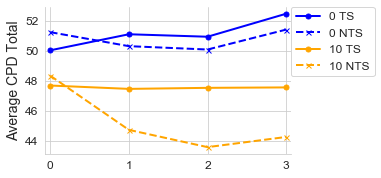

In [20]:
plt.rc('xtick',labelsize=12)
plt.rc('ytick',labelsize=12)
sns.set_style("whitegrid")
#sns.set_context("paper")
plt.figure(figsize=(4.4,2.7))
T=np.array(list(sub_df.index))
for sample in  list(sub_df.columns):
    y=sub_df[sample].tolist()
    y=[(x / norm_dict[sample[0:4]])*1000000 for x in y]
    if sample[5:7]=='TS':
        marker='o'
        line='-'
    else:
        marker='x'
        line='--'
    
    if label_dict[sample[0:4]].split()[1]=='0':
        color='blue'
    if label_dict[sample[0:4]].split()[1]=='10':
        color='orange'
    if label_dict[sample[0:4]].split()[1]=='20':
        color='black'
    if label_dict[sample[0:4]].split()[1]=='30':
        color='red'
    if label_dict[sample[0:4]].split()[1]=='40':
        color='purple'
    
    plt.plot(T,y,label=label_dict[sample[0:4]]+' '+sample[5:7],marker=marker,color=color,linestyle=line,linewidth=2,markersize=5)
plt.legend(["0 TS", "0 NTS","10 TS","10 NTS"],bbox_to_anchor=(1., 1), loc=2, borderaxespad=0.,fontsize=12,fancybox=True)
#plt.axvline(x=49,linewidth=2, color='k')#plt.ylim(0,12)
plt.margins(x=0.02)
#plt.ylim(30,58)


sns.despine(top=True, right=True, left=False, bottom=False)

plt.ylabel('Average CPD Total',fontsize=14)
#plt.savefig('end_gene_highNTS.png',transparent=True,bbox_inches='tight',dpi=600)